# THE Winter School

# **Causal Machine Learning**

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)

## Job Corps Program

The Job Corps is the largest U.S. labor market program targeting disadvantaged youths.
It provides academic, vocational, and social training, as well as health care counseling and job
search assistance, for an average duration of eight to nine months. Mathematica Policy Research carried out a randomized experiment with the Job Corps. About 60% of the experimental participants were randomly selected to receive an offer to participate in the Job Corps. Out of these, 73\% joined the Job Corps program and
actually started to participate after an average duration of 1.4 months. The remaining experimental participants were assigned to the control group. Control group members were not eligible for the
Job Corps programs for three years following randomization (approximately 1\% participated
anyway).

We estimate the effects of receiving an offer to participate in the Job Corps on earnings fours years after the randomisation. We have access to 10,516 observations from the experimental Job Corps data.

**Variable list**

Outcome:
+ **EARNY**: Earnings per week in Year 4

Treatments:
+ **assignment**: Offer to join Job Corps
+ **participation**: Actual participation in Job Corps

Covariates (all dummies):
+ **female**: Dummy for females
+ **age_1**: Aged between 16-17 years
+ **age_2**: Aged between 18-19 years
+ **age_3**: Aged between 20-24 ye
+ **ed0_6**: 0-6 months education program in last year
+ **ed6_12**: 6-12 months education program in last yea
+ **hs_ged**: High school or GED credential
+ **white**: Dummy for white
+ **black**: Dummy for African-American
+ **hisp**: Dummy for Hispanics
+ **oth_eth**: Dummy for other ethnicity
+ **haschld**: Dummy for parents
+ **livespou**: Lives with spouse or partner
+ **everwork**: Ever had job for two weeks or more
+ **yr_work**: Worked in year prior to random assignment
+ **currjob**: Has job at random assignment
+ **job0_3**: Below 3 months employed in last year
+ **job3_9**: 3-9 months employed in last year
+ **job9_12**: 9-12 months employed in last year
+ **earn1**: Yearly earnings less than \$1,000
+ **earn2**: Yearly earnings \$1,000-5,000
+ **earn3**: Yearly earnings \$5,000-10,000
+ **earn4**: Yearly earnings above \$10,000
+ **badhlth**: Dummy for bad healt
+ **welf_kid**: Family on welfare when growing up
+ **got_fs**: Received food stamps in last year
+ **publich**: Public or rent-subsidized housing
+ **got_afdc**: Received AFDC in last year
+ **harduse**: Used hard drugs in last year
+ **potuse**: Smoked marijuana in last year
+ **evarrst**: Ever arrested dummy
+ **pmsa**: Lives in PMSA
+ **msa**: Lives in MSA

## Load Packages

In [1]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('fBasics', 'glmnet', 'tidyverse')

# Load packages
for(pkg in pkgs){
    library(pkg, character.only = TRUE)
}

print('All packages successfully installed and loaded.')

Loading required package: timeDate
Loading required package: timeSeries
Loading required package: Matrix
Loaded glmnet 3.0-1

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks timeSeries::filter(), stats::filter()
✖ dplyr::lag()    masks timeSeries::lag(), stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()


[1] "All packages successfully installed and loaded."


## Load Data

In [2]:
########################  Load Data Frame  ########################
#set.seed(100239) # set starting value for random number generator

# Load data frame
df <- read.csv("Data/job_corps.csv",header=TRUE, sep=",")

print('Data successfully loaded.')

[1] "Data frame successfully loaded and sample selected."


## Means and Standard Deviations

In [3]:
########################  Table with Descriptive Statistics  ########################
desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
  select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=2))

                Mean  Stdev Minimum Maximum  nobs
EARNY4        204.44 195.69       0 2409.91 10516
assignment      0.60   0.49       0    1.00 10516
participation   0.44   0.50       0    1.00 10516
female          0.43   0.49       0    1.00 10516
age_1           0.41   0.49       0    1.00 10516
age_2           0.31   0.46       0    1.00 10516
age_3           0.27   0.45       0    1.00 10516
ed0_6           0.26   0.44       0    1.00 10516
ed6_12          0.36   0.48       0    1.00 10516
hs_ged          0.24   0.43       0    1.00 10516
white           0.26   0.44       0    1.00 10516
black           0.49   0.50       0    1.00 10516
hisp            0.17   0.38       0    1.00 10516
oth_eth         0.07   0.26       0    1.00 10516
haschld         0.20   0.40       0    1.00 10516
livespou        0.06   0.24       0    1.00 10516
everwork        0.80   0.40       0    1.00 10516
yr_work         0.64   0.48       0    1.00 10516
currjob         0.21   0.40       0    1.00 10516


## Prepare Data

In [8]:
########################  Partition the Samples  ########################

# Partition Samples for Cross-Fitting
df_part <- modelr::resample_partition(df, c(obs_A = 0.5, obs_B = 0.5))
df_obs_A <- as.data.frame(df_part$obs_A) # Sample A
df_obs_B <- as.data.frame(df_part$obs_B) # Sample B

print('Samples are partitioned.')

########################  Generate Variables  ########################

# Outcome
earnings_obs_A <- as.matrix(df_obs_A[,1])
earnings_obs_B <- as.matrix(df_obs_B[,1])

# Treatment
treat = 3 #Select treatment 2= offer to participate, 3 = actual participation
treat_obs_A <- as.matrix(df_obs_A[,treat])
treat_obs_B <- as.matrix(df_obs_B[,treat])

# Covariates
covariates_obs_A <- as.matrix(df_obs_A[,c(4:ncol(df_obs_A))])
covariates_obs_B <- as.matrix(df_obs_B[,c(4:ncol(df_obs_B))])

print('The data is now ready for your analysis!')

[1] "Samples are partitioned."
[1] "The data is now ready for your analysis!"


# Nuisance Parameters

We use Lasso to estimate the nuisance parameters.

### Conditional Potential Outcomes

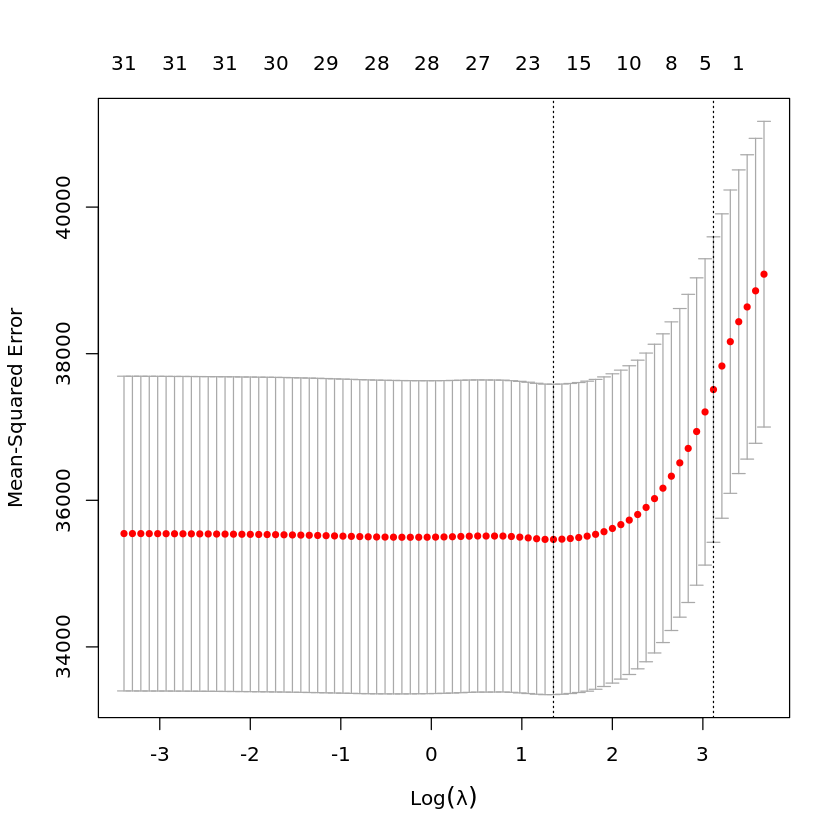

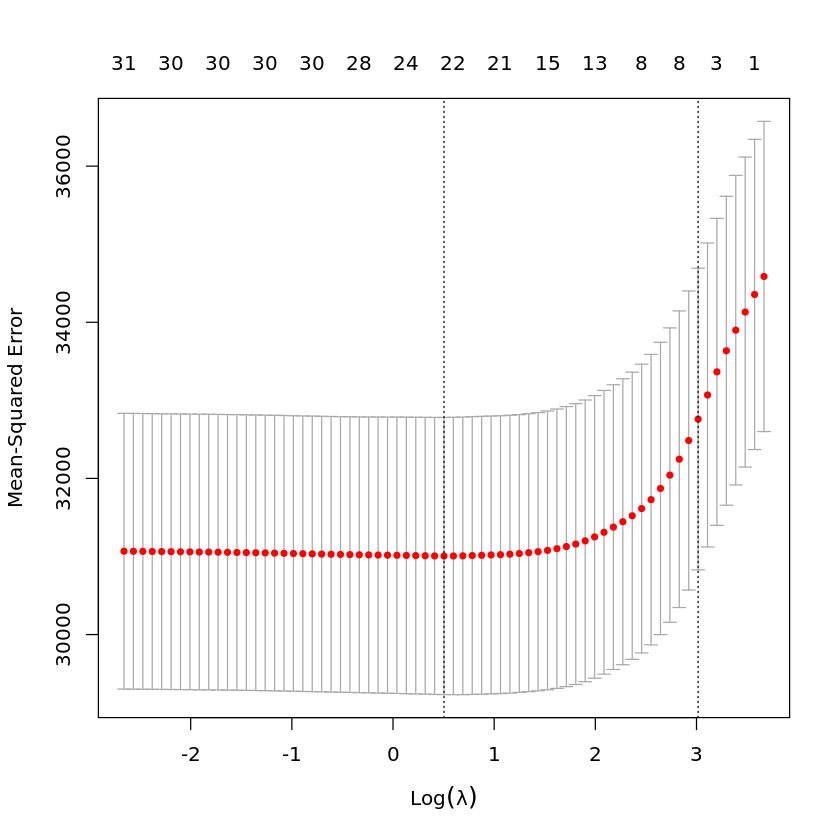

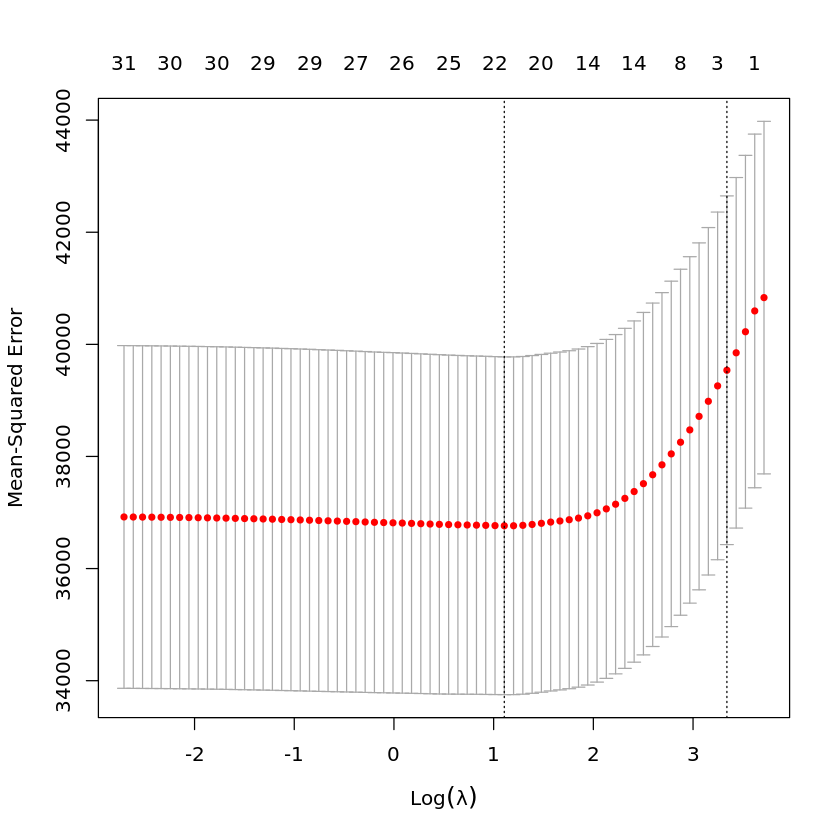

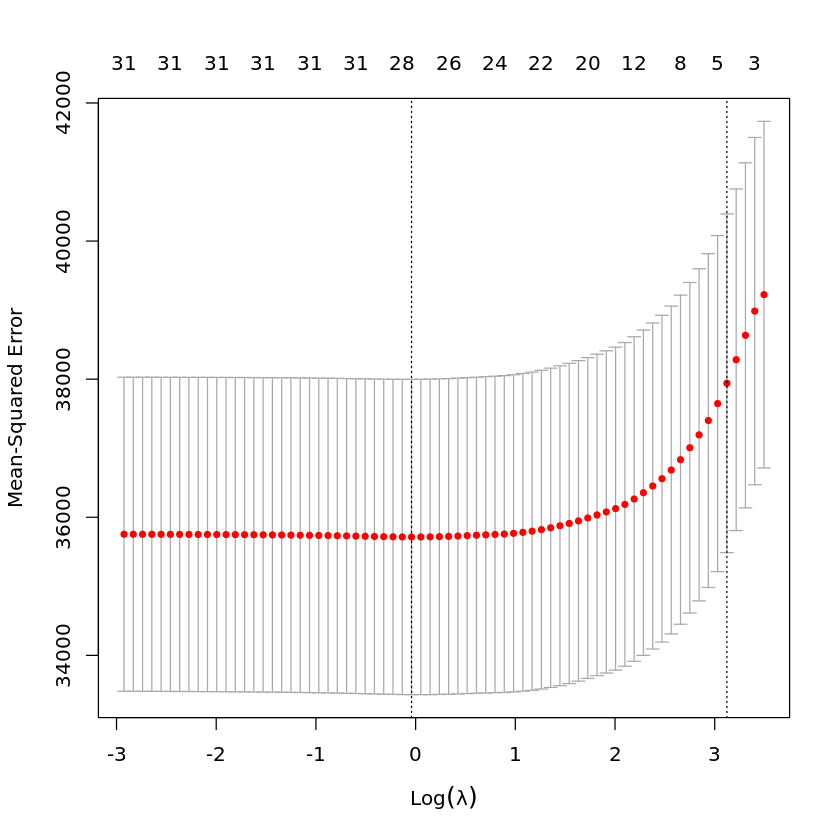

In [10]:
########################  Conditional Potential Earnings  ########################
p = 1 # 1 for LASSO, 0 for Ridge
set.seed(100237)

## Using Sample A to Predict Sample B
# Potential Earnings under Treatment
lasso_y1_A <- cv.glmnet(covariates_obs_A[treat_obs_A==1,], earnings_obs_A[treat_obs_A==1,],
                              alpha=p, type.measure = 'mse')
plot(lasso_y1_A)
fit_y1_A <- glmnet(covariates_obs_A[treat_obs_A==1,], earnings_obs_A[treat_obs_A==1,]
                        ,lambda = lasso_y1_A$lambda.min)
y1hat_B <- predict(fit_y1_A, covariates_obs_B)

# Potential Earnings under Non-Treatment
lasso_y0_A <- cv.glmnet(covariates_obs_A[treat_obs_A==0,], earnings_obs_A[treat_obs_A==0,],
                              alpha=p, type.measure = 'mse')
plot(lasso_y0_A)
fit_y0_A <- glmnet(covariates_obs_A[treat_obs_A==0,], earnings_obs_A[treat_obs_A==0,]
                        ,lambda = lasso_y0_A$lambda.min)
y0hat_B <- predict(fit_y0_A, covariates_obs_B)

## Using Sample B to Predict Sample A
# Potential Earnings under Treatment
lasso_y1_B <- cv.glmnet(covariates_obs_B[treat_obs_B==1,], earnings_obs_B[treat_obs_B==1,],
                              alpha=p, type.measure = 'mse')
plot(lasso_y1_B)
fit_y1_B <- glmnet(covariates_obs_B[treat_obs_B==1,], earnings_obs_B[treat_obs_B==1,]
                        ,lambda = lasso_y1_B$lambda.min)
y1hat_A <- predict(fit_y1_B, covariates_obs_A)

# Potential Earnings under Non-Treatment
lasso_y0_B <- cv.glmnet(covariates_obs_B[treat_obs_B==0,], earnings_obs_B[treat_obs_B==0,],
                              alpha=p, type.measure = 'mse')
plot(lasso_y0_B)
fit_y0_B <- glmnet(covariates_obs_B[treat_obs_B==0,], earnings_obs_B[treat_obs_B==0,]
                        ,lambda = lasso_y0_B$lambda.min)
y0hat_A <- predict(fit_y0_B, covariates_obs_A, type = 'response')

### Propensity Score

We use a Logit-Lasso to estimate the propensity score.

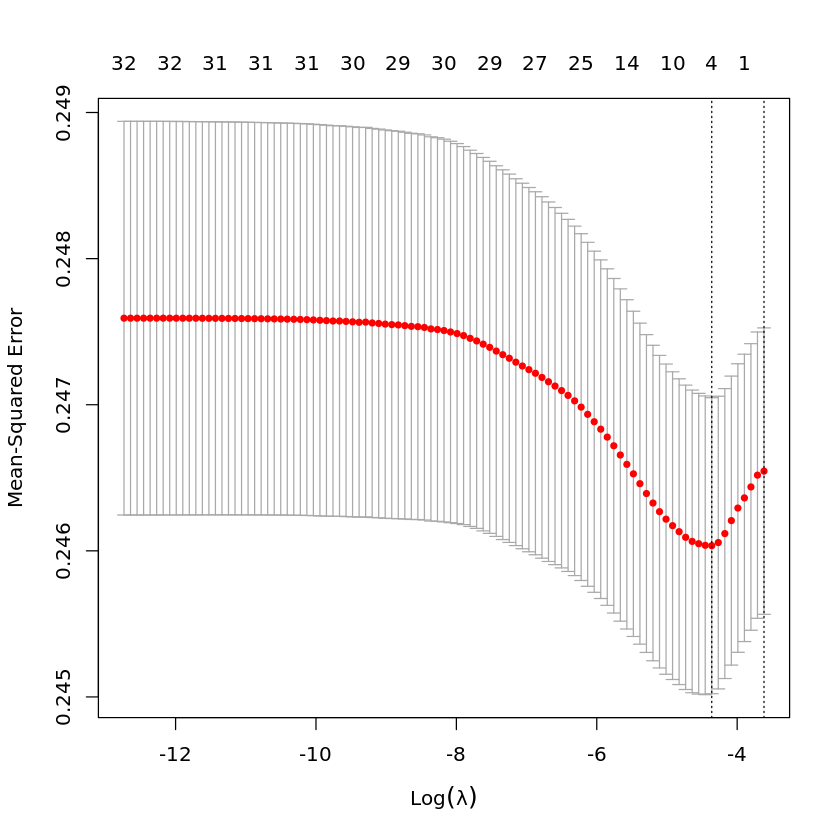

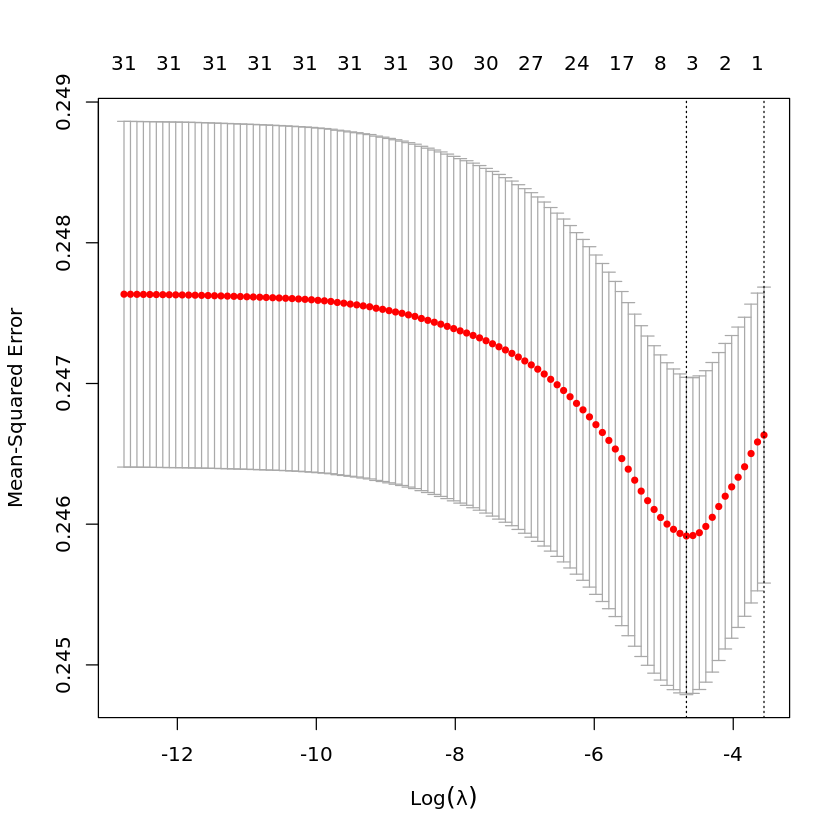

In [11]:
########################  Propensity Score  ########################
p = 1 # 1 for LASSO, 0 for Ridge
set.seed(100236)

# Using Sample A to Predict Sample B
lasso_p_A <- cv.glmnet(covariates_obs_A, treat_obs_A, alpha=p, type.measure = 'mse')
plot(lasso_p_A)
fit_p_A <- glmnet(covariates_obs_A, treat_obs_A,lambda = lasso_p_A$lambda.min)
pscore_B <- predict(fit_p_A, covariates_obs_B)

# Using Sample B to Predict Sample A
lasso_p_B <- cv.glmnet(covariates_obs_B, treat_obs_B, alpha=p, type.measure = 'mse')
plot(lasso_p_B)
fit_p_B <- glmnet(covariates_obs_B, treat_obs_B,lambda = lasso_p_B$lambda.min)
pscore_A <- predict(fit_p_B, covariates_obs_A)

# Modified Outcome Method

### Average Treatment Effects (ATEs)

We use the double machine learning approach to estimate ATEs.

In [13]:
########################  Average Treatment Effects (ATE)  ########################

# Generate Modified Outcome
Y_star_A = invisible(y1hat_A - y0hat_A + treat_obs_A*(earnings_obs_A - y1hat_A)/pscore_A 
            - (1-treat_obs_A)*(earnings_obs_A - y0hat_A)/(1-pscore_A))

Y_star_B = invisible(y1hat_B - y0hat_B + treat_obs_B*(earnings_obs_B - y1hat_B)/pscore_B 
            - (1-treat_obs_B)*(earnings_obs_B - y0hat_B)/(1-pscore_B))

Y_star = invisible(0.5*(mean(Y_star_A) + mean(Y_star_B)))

# Average Treatment Effect (ATE)
ATE <- round(mean(Y_star), digits=1)
psi_A <- Y_star_A- mean(Y_star_A)
psi_B <- Y_star_B- mean(Y_star_B)
SD_ATE <- round(sqrt(0.5*(var(psi_A) + (mean(Y_star_A) - mean(Y_star))^2)/nrow(psi_A) 
                     + 0.5*(var(psi_B) + (mean(Y_star_B) - mean(Y_star))^2)/nrow(psi_B)),digits=1)
print(paste0("Average Treatment Effect (ATE): ", ATE))
print(paste0("Standard Error for ATE: ", SD_ATE))

# Compare results with OLS on full sample
ols <- lm(formula = EARNY4 ~ assignment, data = df)
summary(ols)

[1] "Average Treatment Effect (ATE): 15"
[1] "Standard Error for ATE: 5.2"



Call:
lm(formula = EARNY4 ~ assignment, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-209.28 -168.18  -23.33  100.16 2212.68 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  197.233      3.010  65.525  < 2e-16 ***
assignment    12.046      3.891   3.096  0.00197 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 195.6 on 10514 degrees of freedom
Multiple R-squared:  0.0009107,	Adjusted R-squared:  0.0008157 
F-statistic: 9.584 on 1 and 10514 DF,  p-value: 0.001968
